In [ ]:
#check files are where I think they are
!ls

In [ ]:
#check installation - using Python 3 (ipykernel)
!pip list

In [1]:
#import available libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy as sc

In [ ]:
#2.1 Images
#NOTE:  I did 2.1 images in colab.  I did the other sections in JS2.

In [26]:
#2.1.1 load mnist data set
import torch
import torchvision
import torchvision.datasets as ds
from torchvision.transforms import ToTensor
DataSetMNIST = ds.MNIST(root='.\content\sample_data',train=True,transform=ToTensor(),download=True,)
#2.1.1 extract subset of 1000 images
import torch.utils.data as data_utils
PullIndex = torch.arange(1000)
DataSetMNIST1000 = data_utils.Subset(DataSetMNIST,PullIndex)
print(len(DataSetMNIST1000))

1000


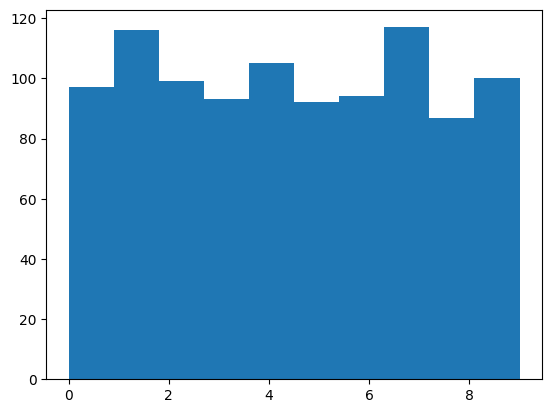

In [48]:
#2.1.2 Histogram of answers in smaller data set
AnswerArray = []
for k in range(0,len(DataSetMNIST1000)):
  (Image,Answer) = DataSetMNIST1000[k]
  AnswerArray = np.append(AnswerArray,Answer)
  if k == 0:
    ImageTensor = Image
  else:
    ImageTensor = torch.cat([ImageTensor,Image])

plt.hist(AnswerArray)
plt.show()

In [2]:
#2.1.3 batch data into subsets
!pip install einops

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 1.6 MB/s eta 0:00:00


In [57]:
#2.1.3 batch data into subsets
from einops import rearrange
print(ImageTensor.size())
ImageBatch = rearrange(ImageTensor, '(b1 b2) x y -> b1 b2 x y ', b2=25)
print(ImageBatch.size())

torch.Size([1000, 28, 28])
torch.Size([40, 25, 28, 28])


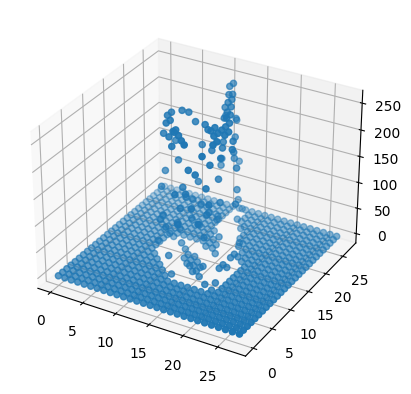

In [5]:
#2.1.4 plot an image
RandomNumber = np.random.rand(1)*1000
RandomIndex = np.round(RandomNumber)
RandomIndex = int(RandomIndex)
(Image,Answer) = DataSetMNIST1000[RandomIndex]
ImageArray = np.array(Image)
#create xplot, yplot
X = np.arange(0, 28, 1)
Y = np.arange(0, 28, 1)
X, Y = np.meshgrid(X, Y)

#surface plot
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.scatter(X,Y,ImageArray)
#surf = ax.plot_surface(X,Y,ImageArray)

plt.show()

In [ ]:
#2.2 Time Series

In [ ]:
#load data
BuildingDataRaw = pd.read_csv('energydata_complete.csv')
print(BuildingDataRaw)

In [ ]:
#find day breakpoints in data
BuildingData = BuildingDataRaw.to_numpy()

#datetime, datetime64, other python date time looks like a mess, so use regular expressions to build relative time
import re
DataLength = len(BuildingData[:,1])
BreakpointsMidnight = []
for k1 in range(0,DataLength):
  x = re.search("00:00:00",BuildingData[k1,0])
  if x:
    BreakpointsMidnight.append(k1)

#print(BreakpointsMidnight)

#check for missing data or too much data for each day
#data points each day
BreakpointsMidnightDouble = np.double(BreakpointsMidnight)
dBreakpointsMidnight = BreakpointsMidnightDouble[1:-1]-BreakpointsMidnightDouble[0:-2]
NumberDays = len(dBreakpointsMidnight)
#10 minute data points in 24 hours
DataPointsPerDayExpected = 24*60/10
#check for errors
ErrorDataPoints = DataPointsPerDayExpected-dBreakpointsMidnight
ErrorDayIndex = 0

for k2 in range(0,NumberDays):
  if np.not_equal(ErrorDataPoints[k2],0.0):
    ErrorDayIndex.append(k2)

print(ErrorDayIndex)

#no days found with missing or extra data points

In [ ]:
#build time channels

#after checking data, build 10 minute spaced relative time array
TimeStep1_sec = 0.0
LengthTime = len(BuildingData[:,1])
TimeStepEnd_sec = LengthTime*600
TimeRelative_sec = np.linspace(TimeStep1_sec,TimeStepEnd_sec,LengthTime)
TimeRelative_hrs = TimeRelative_sec/3600

#build NSM (no. seconds from midnight) channel
#calculate number of seconds from midnight
TimeStepEndPerDay_sec = 24*60*60-600
LengthTimeFromMidnightPerDay = 144
TimeFromMidnightPerDay_sec = np.linspace(TimeStep1_sec,TimeStepEndPerDay_sec,LengthTimeFromMidnightPerDay)
#TimeFromMidnight_sec
#from data start to first midnight
TimeFromMidnight_sec = np.linspace(86400-BreakpointsMidnight[0]*600,86400-600,BreakpointsMidnight[0])
#for each full day
for k3 in range(0,NumberDays+1):
  TimeFromMidnight_sec = np.append(TimeFromMidnight_sec,TimeFromMidnightPerDay_sec)
#for last partial day
TimeStepsLastDay = LengthTime-BreakpointsMidnight[-1]
TimeFromMidnight_sec = np.append(TimeFromMidnight_sec,TimeFromMidnightPerDay_sec[0:TimeStepsLastDay])


In [ ]:
#2.2.1 plot appliance energy consumption
plt.plot(TimeRelative_hrs,BuildingData[:,1])
plt.xlabel("Relative Hours")
plt.ylabel("Appliance Energy Consumption (Wh)")
plt.show()

In [ ]:
#2.2.1 plot appliance energy consumption for one week
IndexWeekStart = BreakpointsMidnight[11] #pick the 11th day in the data set to start a week
IndexWeekEnd = BreakpointsMidnight[18]-1 #data for that week end one data point before 18th day starts
plt.plot(TimeRelative_hrs[IndexWeekStart:IndexWeekEnd],BuildingData[IndexWeekStart:IndexWeekEnd,1])
plt.xlabel("Relative Hours")
plt.ylabel("Appliance Energy Consumption (Wh)")
plt.show()

In [ ]:
#2.2.2 plot hourly consumption heat map for one week

#create 24x7 map (hours x days)
IndexWeekStart = BreakpointsMidnight[11] #pick the 11th day in the data set to start a week
IndexWeekEnd = BreakpointsMidnight[18] #data for that week end one data point before 18th day starts
IndexDays = np.linspace(IndexWeekStart,IndexWeekEnd,8)
IndexDataPtsPerHour = np.linspace(0,144,25)
ConsumptionEnergyMap = np.zeros((24,len(IndexDays)-1))
for k1 in range(len(IndexDays)-1):
  IndexDayStart = round(IndexDays[k1])
  IndexDayEnd = round(IndexDays[k1+1])
  EnergyPerDay = BuildingData[IndexDayStart:IndexDayEnd,1]
  for k2 in range(len(IndexDataPtsPerHour)-1):
    IndexHourStart = round(IndexDataPtsPerHour[k2])
    IndexHourEnd = round(IndexDataPtsPerHour[k2+1]-1)
    EnergyPerHourPerDay = np.sum(EnergyPerDay[IndexHourStart:IndexHourEnd])
    ConsumptionEnergyMap[k2,k1] = EnergyPerHourPerDay

#plot heat map
plt.imshow(ConsumptionEnergyMap)
plt.xlabel("Day")
plt.ylabel("Hour")
plt.show()

In [ ]:
#2.2.3 plot histogram of appliance energy consumption
plt.hist(BuildingData[:,1],bins=50)
plt.xlabel('Appliance Energy Consumption (Wh)')
plt.ylabel('Frequency')
plt.show()

In [ ]:
#2.2.4 plot appliance energy consumption vs. NSM
plt.plot(TimeFromMidnight_sec,BuildingData[:,1],marker='o',linestyle='none')
plt.xlabel("Number of seconds from midnight")
plt.ylabel("Appliance Energy Consumption (Wh)")
plt.show()

In [ ]:
#2.2.5 plot appliance energy consumption vs. barometer
plt.plot(BuildingData[:,-7],BuildingData[:,1],marker='o',linestyle='none')
plt.xlabel('Barometer (mmHg)')
plt.ylabel('Appliance Energy Consumption (Wh)')
plt.show()

In [ ]:
#2.2.6 Why is there a correlation between applicance energy and time of day? Barometer?

#Appliance energy correlation to number of seconds from midnight is likely due to consistent occupant
#activity at similar times from day to day. Low energy consumption around midnight and early morning
#is expected due to sleep, and high energy consumption in mid day and early evening is expected for meal prep.

#Appliance energy correlation to barometer is likely to the link between barometer and weather. Low
#barometer generally means cloud cover and potential precipitation, so I would expect these conditions
#to have higher energy use than high barometer periods. Howerver, this trend is not clear from the plot in 2.2.5.

In [ ]:
#2.3 Multivariate

In [ ]:
#load data
AirfoilDataRaw = pd.read_csv('airfoil_self_noise.dat', sep='\t')
#
#convert to numpy
AirfoilData = AirfoilDataRaw.to_numpy()
print(AirfoilData)

#extract arrays for inputs
Frequency_Hz = AirfoilData[:,0]
AngleAttack_deg = AirfoilData[:,1]
LengthChord_m = AirfoilData[:,2]
VelocityInf_mps = AirfoilData[:,3]
DisplacementSuctionLayer_m = AirfoilData[:,4]
#extract array for output
SoundPressure_dB = AirfoilData[:,5]

In [ ]:
#function for calculating channel statistics
from scipy.stats import kurtosis, skew
def CalculateStatistics(DataChannel):
  MeanChannel = np.mean(DataChannel)
  MedianChannel = np.median(DataChannel)
  KurtosisChannel = kurtosis(DataChannel)
  SkewChannel = skew(DataChannel)
  RangeChannel = np.max(DataChannel)-np.min(DataChannel)
  return MeanChannel, MedianChannel, KurtosisChannel, SkewChannel, RangeChannel

In [ ]:
#calculate channel statistics
StatsFrequencyInput = CalculateStatistics(Frequency_Hz)
StatsAngleAttackInput = CalculateStatistics(AngleAttack_deg)
StatsLengthChordInput = CalculateStatistics(LengthChord_m)
StatsVelocityFSInput = CalculateStatistics(VelocityInf_mps)
StatsDisplacementSLInput = CalculateStatistics(DisplacementSuctionLayer_m)
StatsSoundPressureOutput = CalculateStatistics(SoundPressure_dB)

#show statistics (mean, median, kurtosis, skew, range)
print(StatsFrequencyInput)
print(StatsAngleAttackInput)
print(StatsLengthChordInput)
print(StatsVelocityFSInput)
print(StatsDisplacementSLInput)
print(StatsSoundPressureOutput)